In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

# Find the dataset @ (CSV files 2022-04-21, https://webrobots.io/kickstarter-datasets/)
# download link: https://s3.amazonaws.com/weruns/forfun/Kickstarter/Kickstarter_2022-04-21T03_20_08_060Z.zip

In [2]:
# get db connection
load_dotenv()
db_connection = os.getenv("KICKSTARTER_DB_URL")

# init database engine
engine = create_engine(db_connection)

In [3]:
# Query the database for data to build models.
query = """
        SELECT  state, 
                country, 
                fx_rate, 
                goal, 
                created_at, 
                launched_at, 
                state_changed_at, 
                deadline, 
                category.name, 
                parent_name 
        FROM kickstarters
        INNER JOIN category 
        ON kickstarters.id=category.kickstarter_id
        WHERE state='failed' OR state='successful';
        """
        #  	
model_data = pd.read_sql(query, engine)
model_data.head()

,state,country,fx_rate,goal,created_at,launched_at,state_changed_at,deadline,name,parent_name
0,successful,US,1.000000,5000.0,1609376406,1609545583,1611968831,1611968831,Cookbooks,Food
1,successful,HK,0.127500,350000.0,1606278560,1608912106,1614096106,1614096106,Cookbooks,Food
2,successful,ES,1.081901,50.0,1606477096,1606751262,1607900340,1607900340,Cookbooks,Food
3,successful,US,1.000000,65000.0,1604500905,1606194068,1610082068,1610082068,Cookbooks,Food
4,successful,GB,1.304140,10600.0,1605454727,1605981895,1608573895,1608573895,Cookbooks,Food


In [4]:
# create goal_usd column so that all goal amounts are in the same units, drop fx_rate and goals afterward
model_data['goal_usd'] = model_data['fx_rate']*model_data['goal']
model_data = model_data.drop(columns=['fx_rate', 'goal'])

# create total days active column as another metric
model_data['total_days_active'] = (model_data.deadline-model_data.launched_at)*0.00001157
model_data['launch_time'] = (model_data.launched_at-model_data.created_at)*0.00001157
model_data = model_data.drop(columns=['state_changed_at', 'deadline', 'launched_at'])
model_data.head()

,state,country,created_at,name,parent_name,goal_usd,total_days_active,launch_time
0,successful,US,1609376406,Cookbooks,Food,5000.000000,28.036979,1.957378
1,successful,HK,1606278560,Cookbooks,Food,44624.926500,59.978880,30.470127
2,successful,ES,1606477096,Cookbooks,Food,54.095050,13.294832,3.172101
3,successful,US,1604500905,Cookbooks,Food,65000.000000,44.984160,19.589896
4,successful,GB,1605454727,Cookbooks,Food,13823.881138,29.989440,6.099334


### Encoding of non neumerical features

In [5]:
# init encoder for x values
encoder = LabelEncoder()

# new encoder for y variable (to make sure that we can reverse encoding)
y_encoder = LabelEncoder()
model_data['state'] = y_encoder.fit_transform(model_data['state'])

# encode boolean and string type columns
encoding_columns = (model_data.select_dtypes(include=['bool', 'object'])).columns
for column in encoding_columns:
    model_data[column] = encoder.fit_transform(model_data[column])

### Build Validation and training datasets.

In [6]:
# Drop NA's
model_data = model_data.dropna()
model_data

,state,country,created_at,name,parent_name,goal_usd,total_days_active,launch_time
0,1,24,1609376406,7,4,5000.000000,28.036979,1.957378
1,1,11,1606278560,7,4,44624.926500,59.978880,30.470127
2,1,7,1606477096,7,4,54.095050,13.294832,3.172101
3,1,24,1604500905,7,4,65000.000000,44.984160,19.589896
4,1,9,1605454727,7,4,13823.881138,29.989440,6.099334
...,...,...,...,...,...,...,...,...
28538,0,24,1632678330,33,8,10000.000000,14.994720,3.986328
28539,0,3,1632726042,33,8,39722.546000,60.020532,2.673549
28540,0,6,1631517750,33,8,145430.220000,29.989440,15.026699
28541,0,24,1429554526,23,9,35000.000000,29.989440,8.875729


### Train/test splits for Test and Validation models.

In [7]:
# split into X and y variables
X = model_data.drop(columns=['state'])
y = model_data.state

# generate 70% train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                       random_state = 1,
                                                       stratify = y)

### Scale values using standard scaler

In [8]:
# init standard scaler
scaler = StandardScaler()

# scale Train and testing set, columns=X.columns to keep column headers.
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_train_scaled.head()

,country,created_at,name,parent_name,goal_usd,total_days_active,launch_time
0,0.63176,1.325536,0.522041,-1.130818,-0.033591,-0.258852,0.576642
1,0.63176,-1.124011,-0.981750,-0.411787,-0.030914,-0.262219,-0.337408
2,0.63176,0.734846,-0.451000,-1.490333,-0.025561,0.088453,0.467401
3,0.63176,-1.039018,-0.804834,0.666759,-0.032922,-0.262219,0.309851
4,0.63176,1.222336,0.964333,-0.411787,-0.034260,-0.204127,-0.154006


---

# Random Forest Classifier

In [9]:
# init and fit RF classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [10]:
# perform predictions on testing and validation data
predictions  = rf_classifier.predict(X_test_scaled)

In [11]:
# decode values using inverse transform
rf_predictions_decoded = y_encoder.inverse_transform(predictions)
y_test_decoded = y_encoder.inverse_transform(y_test)

In [12]:
# view model importance of features for the model
importances = pd.DataFrame(zip(X.columns, rf_classifier.feature_importances_), columns = ['Feature','Importance value']).set_index('Feature')
importances

,Importance value
Feature,
country,0.039854
created_at,0.202631
name,0.219853
parent_name,0.081082
goal_usd,0.166626
total_days_active,0.111297
launch_time,0.178657


In [13]:
# classification reports for the test and validation set
rf_report = classification_report(y_test_decoded, rf_predictions_decoded)
print (rf_report)

              precision    recall  f1-score   support

      failed       0.76      0.72      0.74      2799
  successful       0.87      0.89      0.88      5764

    accuracy                           0.83      8563
   macro avg       0.81      0.81      0.81      8563
weighted avg       0.83      0.83      0.83      8563



In [14]:
# view confusion matrix (0=failed, 1=success)
rf_cm = pd.DataFrame(confusion_matrix(y_test_decoded, rf_predictions_decoded), index=['Failed', 'Successful'], columns=['Failed', 'Successful'])
rf_cm

,Failed,Successful
Failed,2027,772
Successful,647,5117


In [15]:
# Calculate the ROC curve and AUC for the testing set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, predictions)
auc_test = round(auc(fpr_test, tpr_test), 3)

# Create a DataFrame with the fpr and tpr results
roc_df_test = pd.DataFrame({"FPR Test": fpr_test, "TPR Test": tpr_test})

<AxesSubplot:title={'center':'Test ROC Curve (AUC=0.806)'}, xlabel='FPR Test'>

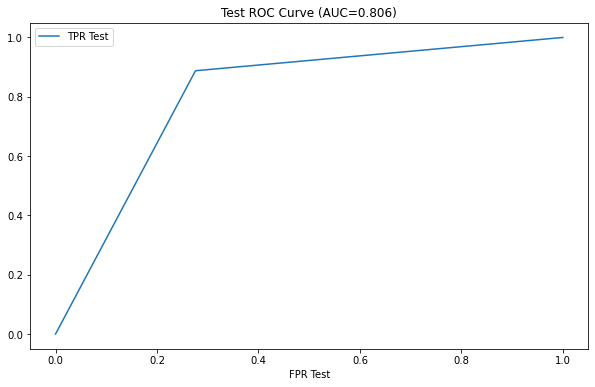

In [16]:
# Plot test set ROC curve
roc_df_test.plot(figsize = (10,6), x="FPR Test", y="TPR Test", title=f"Test ROC Curve (AUC={auc_test})")

---

# SVM Classifier

In [17]:
svm_classifier = SVC(kernel='linear', max_iter=500)
svm_classifier

SVC(kernel='linear', max_iter=500)

In [18]:
svm_classifier.fit(X_train_scaled, y_train)

/Users/stuartperry/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(kernel='linear', max_iter=500)

In [19]:
# Score the accuracy
svm_classifier.score(X_train_scaled, y_train)

0.5767767767767767

In [20]:
# Make predictions using the test data
svm_predictions = svm_classifier.predict(X_test_scaled)
svm_predictions_decoded = y_encoder.inverse_transform(svm_predictions)

In [21]:
# Display the confusion matrix
svm_cm = confusion_matrix(y_test_decoded, svm_predictions_decoded)
svm_cm = pd.DataFrame(confusion_matrix(y_test_decoded, svm_predictions_decoded), index=['Failed', 'Successful'], columns=['Failed', 'Successful'])
svm_cm

,Failed,Successful
Failed,891,1908
Successful,1650,4114


In [22]:
# Calculate classification report
print(classification_report(y_test_decoded, svm_predictions_decoded))

              precision    recall  f1-score   support

      failed       0.35      0.32      0.33      2799
  successful       0.68      0.71      0.70      5764

    accuracy                           0.58      8563
   macro avg       0.52      0.52      0.52      8563
weighted avg       0.57      0.58      0.58      8563



---
# SKLearn Neural Network Classifier

In [23]:
# init and fit Neural Networks classifier
nn_classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(4, 2), random_state=1)

In [24]:
# Fit the data
nn_classifier.fit(X_train_scaled, y_train)

/Users/stuartperry/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(4, 2), random_state=1,
              solver='lbfgs')

In [25]:
nn_classifier.score(X_test_scaled, y_test)

0.7662034333761533

In [26]:
# Make predictions using the test data
nn_predictions = nn_classifier.predict(X_test_scaled)
nn_predictions_decoded = y_encoder.inverse_transform(nn_predictions)

In [27]:
# Display the confusion matrix
nn_cm = confusion_matrix(y_test_decoded, nn_predictions_decoded)
nn_cm = pd.DataFrame(confusion_matrix(y_test_decoded, nn_predictions_decoded), index=['Failed', 'Successful'], columns=['Failed', 'Successful'])
nn_cm

,Failed,Successful
Failed,1560,1239
Successful,763,5001


In [28]:
# Calculate classification report
print(classification_report(y_test_decoded, nn_predictions_decoded))

              precision    recall  f1-score   support

      failed       0.67      0.56      0.61      2799
  successful       0.80      0.87      0.83      5764

    accuracy                           0.77      8563
   macro avg       0.74      0.71      0.72      8563
weighted avg       0.76      0.77      0.76      8563



---
 # XGBoost Classifier

In [29]:
# init datasets as XGB matrices
xgb_train = xgb.DMatrix(np.array(X_train_scaled), label=np.array(y_train))
xgb_test = xgb.DMatrix(np.array(X_test_scaled), label=np.array(y_test))

# specify parameters via map
param = {
    'max_depth':5, 
    'eta':1, 
    'num_class':2, 
    'gamma':0,
    'max_depth':6,
    'min_child_weight':10,
    'num_parallel_tree':1
    }
num_round = 5

# fit XGB classifier
xgb_classifier = xgb.train(param, xgb_train, num_round)

In [30]:
# generate predictions
xgb_predictions = xgb_classifier.predict(xgb_test).astype(int)

In [31]:
xgb_predictions_decoded = y_encoder.inverse_transform(xgb_predictions)

In [32]:
# Display the confusion matrix
xgb_cm = confusion_matrix(y_test_decoded, xgb_predictions_decoded)
xgb_cm = pd.DataFrame(confusion_matrix(y_test_decoded, xgb_predictions_decoded), index=['Failed', 'Successful'], columns=['Failed', 'Successful'])
xgb_cm

,Failed,Successful
Failed,1947,852
Successful,639,5125


In [33]:
# Calculate classification report
print(classification_report(y_test_decoded, xgb_predictions_decoded))

              precision    recall  f1-score   support

      failed       0.75      0.70      0.72      2799
  successful       0.86      0.89      0.87      5764

    accuracy                           0.83      8563
   macro avg       0.81      0.79      0.80      8563
weighted avg       0.82      0.83      0.82      8563

